In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [197]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
train.groupby('Attrition').mean()

,Id,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,...,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
Attrition,,,,,,,,,,,,,,,,,,,,,
0,499.385528,37.480427,8.860024,2.925267,1030.077106,2.767497,2.763938,2.795967,6792.187426,2.676157,...,3.151839,0.838671,11.846975,2.883749,7.406880,4.519573,2.201661,4.302491,2.995255,1.0
1,1152.896815,33.675159,10.675159,2.840764,969.745223,2.515924,2.528662,2.471338,4704.484076,2.853503,...,3.159236,0.535032,7.910828,2.611465,4.681529,2.643312,1.885350,2.745223,3.286624,1.0


In [198]:
ttrain=train.drop('Attrition',axis=1)
all_data = pd.concat((ttrain.loc[:,'Age':],
                      test.loc[:,'Age':]))
all_data.drop(['EmployeeNumber','Behaviour'],axis=1,inplace=True)
all_data = pd.get_dummies(all_data)



In [199]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
X=np.array(all_data['Age'])
X=X.reshape(-1,1)
est.fit(X)
all_data['Age'] = est.transform(X)

In [200]:
est = KBinsDiscretizer(n_bins=19, encode='ordinal', strategy='uniform')
X=np.array(all_data['MonthlyIncome'])
X=X.reshape(-1,1)
est.fit(X)
all_data['MonthlyIncome'] = est.transform(X)

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [202]:
ttrain = all_data[:train.shape[0]]
ttest = all_data[train.shape[0]:]
y = train.Attrition
y

0       0
1       0
2       1
3       0
4       0
       ..
1623    1
1624    1
1625    1
1626    1
1627    1
Name: Attrition, Length: 1628, dtype: int64

In [203]:
# from sklearn.model_selection import GridSearchCV
# param_grid = dict(n_estimators=np.array([50,100,200,300,400,500,1000,1500]))
# model = RandomForestClassifier()
# kfold = KFold(n_splits=10)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
# grid_result = grid.fit(ttrain, y)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [204]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(ttrain)
test_rescaled = scaler.fit_transform(ttest)
from sklearn.decomposition import PCA

pca = PCA(n_components= 25)
X_train = pca.fit_transform(train_rescaled)
X_test = pca.transform(test_rescaled)

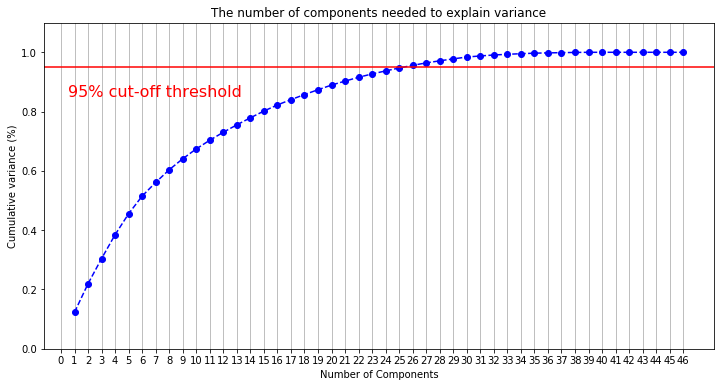

In [205]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(ttrain)
test_rescaled = scaler.fit_transform(ttest)
from sklearn.decomposition import PCA
pca = PCA().fit(train_rescaled)


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 47, step=1)
Y  = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, Y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 47, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [206]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRandom', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, ttrain, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.228497 (0.018513)
ScaledRandom: -0.020859 (0.018446)
ScaledKNN: -0.142331 (0.115520)
ScaledCART: -0.080982 (0.063804)
ScaledGBM: -0.101284 (0.044105)


In [191]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [192]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(ttrain, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.9min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [193]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [194]:
rf = RandomForestClassifier(n_estimators = 1400,min_samples_split = 5,min_samples_leaf=1,max_features= 'sqrt',max_depth=80,bootstrap=False)
rf.fit(X_train, y)
predictions = rf.predict_proba(X_test)[:,1]

In [178]:
# from sklearn import preprocessing
# from sklearn import utils
# lab_enc = preprocessing.LabelEncoder()
# training_scores_encoded = lab_enc.fit_transform(y)
# print(training_scores_encoded)
# print(utils.multiclass.type_of_target(y))
# print(utils.multiclass.type_of_target(y.astype('int')))
# print(utils.multiclass.type_of_target(training_scores_encoded))

In [195]:
solution = pd.DataFrame({"id":test.Id, "Attrition":predictions})
solution.to_csv("binnedpca(SystematicApproach)2.csv", index = False)